In [2]:
from rdflib import Graph, URIRef, Namespace, Literal, XSD, RDF
from rdflib.plugins.stores.sparqlstore import SPARQLStore
from tqdm.notebook import tqdm
import pandas as pd
from copy import deepcopy
import numpy
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from rapidfuzz import process, fuzz, distance
import numpy as np
import math

import torch
from transformers import BertTokenizer
from transformers import BertModel
from sklearn.metrics.pairwise import cosine_similarity

import concurrent.futures

import matplotlib.pyplot as plt

import numbers

import dateutil.parser as dparser
import datetime

In [144]:
GRAPH_1 = "/Users/yamamotobikutorueiichi/codes/custom_paris/star-wars-wiki.xml"
GRAPH_1_INV_FUNC_PATH = '/Users/yamamotobikutorueiichi/codes/custom_paris/sww-inversability.csv'

GRAPH_2 = "https://dbpedia.org/sparql"
GRAPH_2_INV_FUNC_PATH = '/Users/yamamotobikutorueiichi/codes/gollumn - subdataset/sw-dbpedia/dbpedia-inversability.csv'

#GRAPH_2 = "http://localhost:8890/sparql"
SUBJECT = 'subject'
PREDICATE = 'predicate'
INVERSE_FUNCTIONALITY = 'inverse_functionality'
INVERSABILITY = 'inversability'
MAX_LENGTH_FULL_MATCH = 10000
LABEL_PREDICATE = "http://www.w3.org/2000/01/rdf-schema#label"
FILE_FOLDER = "/Users/yamamotobikutorueiichi/codes/gollumn - subdataset/sw-dbpedia/sw-dbpedia/"
GRAPH_1_ABSTRACT = "http://dbkwik.webdatacommons.org/ontology/abstract"
GRAPH_2_ABSTRACT = "http://dbkwik.webdatacommons.org/ontology/abstract"
CATEGORICAL = 'categorical'
DATASET = '/Users/yamamotobikutorueiichi/codes/triple matching/sw-dbpedia-gold.csv'
GENERAL_THRESHOLD = 0.1

In [4]:
graph_1 = Graph()
graph_1.parse(GRAPH_1)

<Graph identifier=N79af34b09c6345e1b46e3f67a01a967d (<class 'rdflib.graph.Graph'>)>

In [5]:
graph_1_inv_func_df = pd.read_csv(GRAPH_1_INV_FUNC_PATH)


In [6]:
graph_1_func_dict = dict()

for _, row in graph_1_inv_func_df.iterrows():
    graph_1_func_dict[row['predicate']] = row['functionality']

In [7]:
#graph_2 = Graph()
#graph_2.parse(GRAPH_2)
graph_2 = Graph("SPARQLStore")
graph_2.open(GRAPH_2)

In [8]:
graph_2_inv_func_df = pd.read_csv(GRAPH_2_INV_FUNC_PATH)


In [9]:
graph_2_func_dict = dict()

for _, row in graph_2_inv_func_df.iterrows():
    graph_2_func_dict[row['predicate']] = row['functionality']

In [13]:
entity_sim_df = pd.read_csv(FILE_FOLDER + "entity_sim_9.csv")

In [15]:
entity_sim_dict = dict()

for _, row in tqdm(entity_sim_df.iterrows(), total=len(entity_sim_df)):
    e1 = row['e1']
    e2 = row['e2']
    sim = row['sim']
    
    entity_sim_dict.setdefault(e1, {})[e2] = sim

  0%|          | 0/17969557 [00:00<?, ?it/s]

In [16]:
one_to_one_df = entity_sim_df.sort_values('sim', ascending=False).drop_duplicates('e1').drop_duplicates('e2')

In [17]:
one_to_one_df = one_to_one_df[one_to_one_df['sim'] > GENERAL_THRESHOLD]

In [18]:
class_sim_df = pd.read_csv(FILE_FOLDER + 'class_sem_prob.csv')

for _, row in class_sim_df.iterrows():
    c1 = row['c1']
    c2 = row['c2']
    sim = row['sim']
    
    entity_sim_dict.setdefault(c1, {})[c2] = sim

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yamamotobikutorueiichi/codes/gollumn - subdataset/sw-dbpedia/sw-dbpedia/class_sem_prob.csv'

In [19]:
predicate_sim = pd.read_csv(FILE_FOLDER + 'predicate_sem_prob.csv')

In [20]:
threshold_predicate_sim = predicate_sim[predicate_sim['sim'] > GENERAL_THRESHOLD]

In [23]:
threshold_predicate_sim['mul_sim'] = threshold_predicate_sim.apply(
    lambda x: x['sim'] * (graph_1_func_dict.get(x['p1'], 0) if x['p1'] in graph_1_func_dict else 0) * 
    graph_2_func_dict[x['p2']], axis=1)



In [24]:
threshold_predicate_sim = threshold_predicate_sim.drop(index=0)

# Get predicate types

In [26]:
mul_pred_sim = threshold_predicate_sim[threshold_predicate_sim['mul_sim'] > GENERAL_THRESHOLD]

In [27]:
def get_types(graph, pred):
    pred_uri = URIRef(pred)
    type_dict = dict()
    
    for s, o in graph.subject_objects(pred_uri):
        o_type = None
        if type(o) == Literal:
            o_type = type(o.toPython())
        else:
            o_type = type(o)
        
        if not o_type in type_dict:
            type_dict[o_type] = 0
        type_dict[o_type] += 1
        
    return type_dict

In [28]:
p1_type_dict = dict()
p2_type_dict = dict()

mul_pred_sim_len = len(mul_pred_sim)

for _, row in tqdm(mul_pred_sim.iterrows(), total=mul_pred_sim_len):
    p1 = row['p1']
    p2 = row['p2']
    
    if not p1 in p1_type_dict:
        p1_type_dict[p1] = get_types(graph_1, p1)
    if not p2 in p2_type_dict:
        p2_type_dict[p2] = get_types(graph_2, p2)

  0%|          | 0/595 [00:00<?, ?it/s]

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-1948-11-30'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-1958-02-07'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-216-08-02'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-043-04-21'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-058-09-14'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-494-08-29'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x1054bd550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/berkeley/lib/python3.9/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_

# Predicate type definition

In [29]:
def prop_type_dict(p_type_dict):
    p_prop_type_dict = dict()
    for p, type_dict in p_type_dict.items():
        total_count = 0
        p_prop_type_dict[p] = dict()

        for type_key, type_count in type_dict.items():
            total_count += type_count
            p_prop_type_dict[p][type_key] = type_count

        for type_key in p_prop_type_dict[p]:
            p_prop_type_dict[p][type_key] /= total_count
    return p_prop_type_dict

In [30]:
p1_prop_type_dict = prop_type_dict(p1_type_dict)
p2_prop_type_dict = prop_type_dict(p2_type_dict)

In [31]:
string_types = [string, Literal, None, str]
number_types = [int, float]
UNDEFINED = 'undefined'
STRING = 'string'
ENTITY = 'entity'
NUMBER = 'numbers'
DATE = 'date'
CATEGORICAL = 'categorical'

In [32]:
def most_common_pred_type(graph, pred_type_dict, predicate):
    type_dict = pred_type_dict[predicate]
    
    most_value = 0
    most_type = ''
    for type_key, type_value in type_dict.items():
        if type_value > most_value:
            most_value = type_value
            most_type = type_key
    
    if most_value < 0.8:
        return UNDEFINED
    
    if most_type == URIRef:
        return ENTITY
    
    if most_type in string_types:
        list_objects = list()
        for s, o in graph.subject_objects(URIRef(predicate)):
            list_objects.append(o)
        
        if len(list_objects) == 0:
            return most_type
        
        set_objects = set(list_objects)
        
        unique_ratio = len(set_objects) / len(list_objects)
        
        if unique_ratio < 0.5:
            return CATEGORICAL
        else:
            return STRING
    
    if most_type in number_types:
        return NUMBER
    
    if most_type == datetime.date:
        return DATE
    
    return UNDEFINED

In [33]:
mul_pred_sim['p1_type'] = mul_pred_sim.apply(lambda x: most_common_pred_type(graph_1, p1_prop_type_dict, x['p1']), axis=1)
mul_pred_sim['p2_type'] = mul_pred_sim.apply(lambda x: most_common_pred_type(graph_2, p2_prop_type_dict, x['p2']), axis=1)



/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/2384685268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_pred_sim['p1_type'] = mul_pred_sim.apply(lambda x: most_common_pred_type(graph_1, p1_prop_type_dict, x['p1']), axis=1)
/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/2384685268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_pred_sim['p2_type'] = mul_pred_sim.apply(lambda x: most_common_pred_type(graph_2, p2_prop_type_dict, x['p2']), axis=1)


In [37]:
p1_most_common_type_dict = dict()
for p in tqdm(set(mul_pred_sim['p1'])):
    p1_most_common_type_dict[p] = most_common_pred_type(graph_1, p1_prop_type_dict, p)
p2_most_common_type_dict = dict()
for p in tqdm(set(mul_pred_sim['p2'])):
    graph_2 = Graph("SPARQLStore")
    graph_2.open(GRAPH_2)
    p2_most_common_type_dict[p] = most_common_pred_type(graph_2, p2_prop_type_dict, p)

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

In [38]:
mul_pred_sim['type_match'] = mul_pred_sim.apply(lambda x: x['p1_type'] == x['p2_type'], axis=1)

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/2372449352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_pred_sim['type_match'] = mul_pred_sim.apply(lambda x: x['p1_type'] == x['p2_type'], axis=1)


In [39]:
def get_category_values(graph, p):
    object_set = set()
    for s, o in graph.subject_objects(URIRef(p)):
        object_set.add(str(o))
    return object_set

In [40]:
p1_categorical_set = set(mul_pred_sim[mul_pred_sim['p1_type'] == CATEGORICAL]['p1'])

In [41]:
p1_categorical_dict = dict()
for elem in p1_categorical_set:
    p1_categorical_dict[elem] = get_category_values(graph_1, elem)

In [43]:
p2_categorical_set = set(mul_pred_sim[mul_pred_sim['p2_type'] == CATEGORICAL]['p2'])
p2_categorical_dict = dict()
for elem in tqdm(p2_categorical_set):
    p2_categorical_dict[elem] = get_category_values(graph_2, elem)

  0%|          | 0/52 [00:00<?, ?it/s]

In [44]:
predicate_sim_dict = dict()

for _, row in threshold_predicate_sim.iterrows():
    predicate_sim_dict.setdefault(row['p1'], {})[row['p2']] = row['mul_sim']

In [45]:
def get_triples(graph, entity):
    entity_uri = URIRef(entity)
    
    predicate_dict = dict()
    
    tries = 0
    success = False
    while not success and tries < 5:
        try:
            for p, o in graph.predicate_objects(entity_uri):
                predicate_dict.setdefault(str(p), list()).append(o)
            
            success = True
        except Exception as e:
            tries += 1
    return predicate_dict

In [103]:
def get_common_triples(e1, e2, sim, triple_1, triple_2):
    p1_set = set(threshold_predicate_sim['p1'])
    p2_set = set(threshold_predicate_sim['p2'])
    triple_1_set = set(triple_1.keys())
    triple_2_set = set(triple_2.keys())
    
    common_set_1 = p1_set.intersection(triple_1_set)
    common_set_2 = p2_set.intersection(triple_2_set)
    
    if not common_set_1 or not common_set_2:
        return []
    
    matching_triple_list = list()
    for p1 in common_set_1:
        p2_dict = predicate_sim_dict[p1]
        
        for p2 in p2_dict.keys():
            if p2_dict[p2] < GENERAL_THRESHOLD:
                continue
            if p2 in common_set_2:
                for o1 in triple_1[p1]:
                    for o2 in triple_2[p2]:
                        matching_triple_list.append({
                            'e1': e1,
                            'p1': p1,
                            'o1': o1,
                            'e2': e2,
                            'p2': p2,
                            'o2': o2,
                            'p1_type': p1_most_common_type_dict[p1],
                            'p2_type': p2_most_common_type_dict[p2],
                            'prob': p2_dict[p2] * sim
                        })
                        
    return matching_triple_list

In [50]:
match_df = pd.read_csv('/Users/yamamotobikutorueiichi/codes/gollumn - subdataset/star-wars-dbpedia.csv')



In [92]:
match_df['e1'] = match_df['e1'].str.replace('http://dbkwik.webdatacommons.org/starwars./resource', 
                                           'http://dbkwik.webdatacommons.org/starwars.wikia.com/resource')

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/1961019814.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  match_df['e1'] = match_df['e1'].str.replace('http://dbkwik.webdatacommons.org/starwars./resource',


In [93]:
threshold_predicate_sim['p1'] = threshold_predicate_sim['p1'].str.replace('http://dbkwik.webdatacommons.org/starwars./property', 
                                           'http://dbkwik.webdatacommons.org/starwars.wikia.com/property')

threshold_predicate_sim['p2'] = threshold_predicate_sim['p2'].str.replace('http://dbkwik.webdatacommons.org/starwars./property', 
                                           'http://dbkwik.webdatacommons.org/starwars.wikia.com/property')



/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/723887699.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  threshold_predicate_sim['p1'] = threshold_predicate_sim['p1'].str.replace('http://dbkwik.webdatacommons.org/starwars./property',
/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/723887699.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  threshold_predicate_sim['p2'] = threshold_predicate_sim['p2'].str.replace('http://dbkwik.webdatacommons.org/starwars./property',


In [94]:
match_df

tuple_set = set(zip(match_df['e1'], match_df['e2']))


In [101]:
one_to_one_df['e1'] = one_to_one_df['e1'].str.replace('http://dbkwik.webdatacommons.org/starwars./resource', 
                                           'http://dbkwik.webdatacommons.org/starwars.wikia.com/resource')

one_to_one_df['e2'] = one_to_one_df['e2'].str.replace('http://dbkwik.webdatacommons.org/starwars./resource', 
                                           'http://dbkwik.webdatacommons.org/starwars.wikia.com/resource')

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/728521539.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  one_to_one_df['e1'] = one_to_one_df['e1'].str.replace('http://dbkwik.webdatacommons.org/starwars./resource',
/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4802/728521539.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  one_to_one_df['e2'] = one_to_one_df['e2'].str.replace('http://dbkwik.webdatacommons.org/starwars./resource',


In [104]:
common_triple_list = list()

for _, row in tqdm(one_to_one_df.iterrows(), total=len(one_to_one_df)):
    entity_1 = row['e1']
    entity_2 = row['e2']
    
    if not (entity_1, entity_2) in tuple_set:
        continue
    
    graph_2 = Graph("SPARQLStore")
    graph_2.open(GRAPH_2)
    
    triple_1 = get_triples(graph_1, entity_1)
    triple_2 = get_triples(graph_2, entity_2)
    
    common_triples = get_common_triples(entity_1, entity_2, row['sim'], triple_1, triple_2)
    
    common_triple_list.extend(common_triples)

  0%|          | 0/37711 [00:00<?, ?it/s]

In [105]:
common_triple_df = pd.DataFrame(common_triple_list)

In [106]:
common_triple_df.to_csv('sww-common-triples.csv')

In [108]:
pd.set_option('display.max_colwidth', None)


In [109]:
def get_entity_label(graph, e):
    label_predicate = URIRef(LABEL_PREDICATE)
    
    label_list = list()
    for o in graph.objects(URIRef(e), label_predicate):
        label_list.append(str(o))
    return label_list

In [110]:
def undefined_similarity(o1, o2):
    if str(o1) == str(o2):
        return 1.0
    else:
        return 1.0

In [111]:
def string_string_similarity(o1, o2):
    return fuzz.WRatio(o1, o2) / 100

In [112]:
def string_entity_similarity(s1, e2, graph):
    entity_label_list = get_entity_label(graph, e2)
    
    max_ratio = 0.0
    for label in entity_label_list:
        new_ratio = fuzz.WRatio(s1, label) / 100
        if max_ratio < new_ratio:
            max_ratio = new_ratio
    return max_ratio

In [113]:
def number_number_similarity(x, y):
    if x == y:
        return 1.0
    difference = x - y
    squared_difference = difference**2
    distance = math.sqrt(squared_difference)
    maximum_distance = abs(x) + abs(y)
    scaled_distance = distance / maximum_distance
    return 1 - scaled_distance

In [114]:
def string_number_similarity(s1, n2):
    number_list = [float(s) for s in re.findall(r'-?\d+\.?\d*', s1)]
    
    # Calculate using Euclidean similarity
    max_sim = 0.0
    for n1 in number_list:
        new_sim = number_number_similarity(n1, n2)
        if max_sim < new_sim:
            max_sim = new_sim
    
    # Calculate using Indel similarity
    edit_similarity = distance.Indel.normalized_similarity(s1, str(n2))
    
    if edit_similarity > max_sim:
        max_sim = edit_similarity
    
    return max_sim

In [115]:
def get_timestamp(d):
    datetime_obj = datetime.datetime.combine(d, datetime.time.min)

    # Convert datetime object to timestamp
    return datetime_obj.timestamp()

In [116]:
def date_date_similarity(d1, d2):
    return number_number_similarity(get_timestamp(d1), get_timestamp(d2))

In [117]:
def string_date_similarity(s1, d2):
    try:
        d1 = dparser.parse(s1,fuzzy=True)
    except Exception as e:
        return 0.0

    return date_date_similarity(d1, d2)

In [118]:
def string_categorical_similarity(s1, c2, categories_2):
    if s1 == c2:
        return 1.0
    
    max_ratio = 0.0
    max_category = ''
    for category in categories_2:
        new_ratio = fuzz.WRatio(s1, category) / 100
        if new_ratio > max_ratio:
            max_ratio = new_ratio
            max_category = category

    if str(max_category).lower() == str(c2).lower():
        return max_ratio
    else:
        return 0.0

In [119]:
def entity_entity_similarity(e1, e2):
    e1_str = str(e1)
    e2_str = str(e2)
    if e1_str in entity_sim_dict and e2_str in entity_sim_dict[e1_str]:
        return entity_sim_dict[e1_str][e2_str]
    return 0.0

In [120]:
def entity_categorical_similarity(e1, c2, graph, categories_2):
    label = get_entity_label(graph, e1)
    
    return string_categorical_similarity(label, c2, categories_2)

In [121]:
def number_date_similarity(n1, d2):
    return number_number_similarity(n1, get_timestamp(d2))

In [122]:
def categorical_categorical_similarity(c1, c2, categories_1, categories_2):
    ratio_1 = string_categorical_similarity(str(c1), c2, categories_2)
    ratio_2 = string_categorical_similarity(str(c2), c1, categories_1)
    if ratio_1 > ratio_2:
        return ratio_1
    return ratio_2

In [123]:
def check_object_type(o):
    if type(o) == URIRef:
        return ENTITY
    
    datatype = type(o.toPython())
    if datatype in number_types:
        return NUMBER
    
    if datatype == datetime.date:
        return DATE
    
    return STRING

In [124]:
def object_predicate_same_type(o_type, p_type):
    if o_type == p_type:
        return True
    if p_type == UNDEFINED:
        return True
    if p_type == CATEGORICAL and o_type in [STRING, ENTITY]:
        return True
    return False

In [125]:
def get_objects_similarity(o1, o2, p1, p2, p1_type, p2_type):
    if str(o1) == str(o2):
        return 1.0
    
    o1_type = check_object_type(o1)
    o2_type = check_object_type(o2)
    

    if o1_type == ENTITY:
        if o2_type == ENTITY:
            return entity_entity_similarity(o1, o2)
        if o2_type == STRING:
            return string_entity_similarity(o2, o1, graph_1)
        if p2_type == CATEGORICAL:
            return entity_categorical_similarity(o1, o2, graph_1, p2_categorical_dict[p2])
    
    o1_python = o1.toPython()
    o2_python = o2.toPython()
    
    if o2_type == ENTITY:
        if o1_type == STRING:
            return string_entity_similarity(o1_python, o2, graph_2)
        if p1_type == CATEGORICAL:
            return entity_categorical_similarity(o2, o1, graph_2, p1_categorical_dict[p1])
    
    if p1_type == CATEGORICAL:
        if p2_type == STRING:
            return string_categorical_similarity(str(o2_python), o1_python, p1_categorical_dict[p1])
    
    if p2_type == CATEGORICAL:
        value = string_categorical_similarity(str(o1_python), o2_python, p2_categorical_dict[p2])
        return value
    
    
    if o1_type == NUMBER:
        if o2_type == NUMBER:
            return number_number_similarity(o1_python, o2_python)
        if o2_type == STRING:
            return string_number_similarity(o2_python, o1_python)
        if o2_type == DATE:
            return number_date_similarity(o1_python, o2_python)
    
    if o2_type == NUMBER:
        if o1_type == STRING:
            return string_number_similarity(o1_python, o2_python)
        if o2_type == DATE:
            return number_date_similarity(o2_python, o1_python)
    
    if o1_type == DATE:
        if o2_type == DATE:
            return date_date_similarity(o1_python, o2_python)
        if o2_type == STRING:
            return string_date_similarity(o2_python, o1_python)
    
    if o2_type == DATE:
        if o2_type == STRING:
            return string_date_similarity(o1_python, o2_python)
    
    if o1_type == STRING and o2_type == STRING:
        return string_string_similarity(o1_python, o2_python)
    
    return 0.0

In [126]:
tqdm.pandas(desc="Processing rows")


common_triple_df['equals'] = common_triple_df.progress_apply(
    lambda x: x['prob'] * get_objects_similarity(x['o1'], x['o2'], x['p1'], x['p2'], x['p1_type'], x['p2_type']),
    axis=1)


Processing rows:   0%|          | 0/85791 [00:00<?, ?it/s]

In [127]:
common_triple_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals
0,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#Thing,entity,entity,0.257337,0.0
1,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://xmlns.com/foaf/0.1/Person,entity,entity,0.257337,0.0
2,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/ontology/Person,entity,entity,0.257337,0.0
3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#NaturalPerson,entity,entity,0.257337,0.0
4,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.wikidata.org/entity/Q19088,entity,entity,0.257337,0.0
...,...,...,...,...,...,...,...,...,...,...
85786,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/Day115155220,entity,entity,0.127616,0.0
85787,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/Measure100033615,entity,entity,0.127616,0.0
85788,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/TimeUnit115154774,entity,entity,0.127616,0.0
85789,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/WikicatDays,entity,entity,0.127616,0.0


In [128]:
tqdm.pandas(desc="Processing rows")

common_triple_df['divergent'] = common_triple_df.progress_apply(
    lambda x: x['prob'] * (1 -  get_objects_similarity(x['o1'], x['o2'], x['p1'], x['p2'], x['p1_type'], x['p2_type'])),
    axis=1)



Processing rows:   0%|          | 0/85791 [00:00<?, ?it/s]

In [129]:
common_triple_df.to_csv('sw-dbpedia-common-triples.csv')

In [130]:
test_df = common_triple_df[
    common_triple_df['p1'] == 'http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/defenses']

In [131]:
test_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent


In [132]:
common_triple_df[(common_triple_df['p1'] == 'http://dbkwik.webdatacommons.org/starwars.wikia.com/property/gender') &
    (common_triple_df['p2'] == 'http://dbkwik.webdatacommons.org/swtor.wikia.com/property/gender')]

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent


In [133]:
common_p1_p2_counts = common_triple_df.groupby(["p1", "p2"]).size().to_frame('size')


In [134]:
common_p1_p2_counts.sort_values('size', ascending=False)[:100]

size
p1                                                                        p2                                                    
http://www.w3.org/1999/02/22-rdf-syntax-ns#type                           http://www.w3.org/1999/02/22-rdf-syntax-ns#type  33924
http://www.w3.org/2000/01/rdf-schema#label                                http://www.w3.org/2000/01/rdf-schema#label       19509
http://www.w3.org/2000/01/rdf-schema#comment                              http://www.w3.org/2000/01/rdf-schema#comment     19380
http://xmlns.com/foaf/0.1/depiction                                       http://xmlns.com/foaf/0.1/depiction               9753
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/occupation   http://dbpedia.org/property/occupation             968
                                                                          http://dbpedia.org/ontology/occupation             601
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/name         http://dbpedia.org/property/name                   581
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/affiliation  http://dbpedia.org/property/affiliation            568
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality  http://dbpedia.org/property/nationality            125
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/url          http://dbpedia.org/property/url                     87
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality  http://dbpedia.org/ontology/nationality             36
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website      http://dbpedia.org/property/website                 32
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/symptoms     http://dbpedia.org/ontology/symptom                 19
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/title        http://dbpedia.org/property/title                   18
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/text         http://dbpedia.org/property/text                    17
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/released     http://dbpedia.org/property/released                17
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/platforms    http://dbpedia.org/property/platforms               17
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/parent       http://dbpedia.org/property/parent                  13
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/founder      http://dbpedia.org/property/founder                 12
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/modes        http://dbpedia.org/property/modes                    9
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/publisher    http://dbpedia.org/property/publisher                9
                                                                          http://dbpedia.org/ontology/publisher                9
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/releaseDate  http://dbpedia.org/property/releaseDate              8
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/species      http://dbpedia.org/property/species                  8
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/gender       http://dbpedia.org/property/gender                   8
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer    http://dbpedia.org/ontology/developer                5
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/headquarters http://dbpedia.org/property/headquarters             5
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer    http://dbpedia.org/property/developer                5
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/releaseDate  http://dbpedia.org/ontology/releaseDate              4
http://dbkwik.webdatacommons.org/starwars.wikia.com/property/founded      http://dbpedia.org/property/founded                

In [135]:
specific_pred_df = common_triple_df[
    (common_triple_df['p1'] == 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type') &
    (common_triple_df['p2'] == 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type')]



In [136]:
specific_pred_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent
0,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#Thing,entity,entity,0.257337,0.0,0.257337
1,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://xmlns.com/foaf/0.1/Person,entity,entity,0.257337,0.0,0.257337
2,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/ontology/Person,entity,entity,0.257337,0.0,0.257337
3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#NaturalPerson,entity,entity,0.257337,0.0,0.257337
4,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.wikidata.org/entity/Q19088,entity,entity,0.257337,0.0,0.257337
...,...,...,...,...,...,...,...,...,...,...,...
85786,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/Day115155220,entity,entity,0.127616,0.0,0.127616
85787,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/Measure100033615,entity,entity,0.127616,0.0,0.127616
85788,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/TimeUnit115154774,entity,entity,0.127616,0.0,0.127616
85789,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/WikicatDays,entity,entity,0.127616,0.0,0.127616


In [137]:
specific_pred_df[specific_pred_df['equals'] > 0.5][['e1', 'e2', 'o1', 'o2', 'equals']].sort_values(
    'equals', ascending=False)[:15]



,e1,e2,o1,o2,equals


In [138]:
specific_pred_df[specific_pred_df['divergent'] > 0.5][['e1', 'e2', 'o1', 'o2', 'divergent']].sort_values(
    'divergent', ascending=False)[:15]



,e1,e2,o1,o2,divergent


In [139]:
specific_pred_df[(specific_pred_df['equals'] < 0.5) & (specific_pred_df['divergent'] < 0.5)][['e1', 'e2', 'o1', 'o2', 'equals', 'divergent']]
                                                       
                                                

,e1,e2,o1,o2,equals,divergent
0,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://dbpedia.org/resource/Andy_Serkis,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://www.w3.org/2002/07/owl#Thing,0.0,0.257337
1,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://dbpedia.org/resource/Andy_Serkis,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://xmlns.com/foaf/0.1/Person,0.0,0.257337
2,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://dbpedia.org/resource/Andy_Serkis,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/ontology/Person,0.0,0.257337
3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://dbpedia.org/resource/Andy_Serkis,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#NaturalPerson,0.0,0.257337
4,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://dbpedia.org/resource/Andy_Serkis,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://www.wikidata.org/entity/Q19088,0.0,0.257337
...,...,...,...,...,...,...
85786,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://dbpedia.org/resource/June_22,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/class/yago/Day115155220,0.0,0.127616
85787,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://dbpedia.org/resource/June_22,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/class/yago/Measure100033615,0.0,0.127616
85788,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://dbpedia.org/resource/June_22,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/class/yago/TimeUnit115154774,0.0,0.127616
85789,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://dbpedia.org/resource/June_22,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/class/yago/WikicatDays,0.0,0.127616


In [140]:
pred_analyze_list = list()

for index, row in tqdm(common_p1_p2_counts.itertuples()):
    p1 = index[0]
    p2 = index[1]
    size = row
    
    specific_pred_df = common_triple_df[
        (common_triple_df['p1'] == p1) &
        (common_triple_df['p2'] == p2)]
    
    equivalent = len(specific_pred_df[specific_pred_df['equals'] > 0.5])
    different = len(specific_pred_df[specific_pred_df['divergent'] > 0.5])
    inconclusive = len(specific_pred_df[(specific_pred_df['equals'] < 0.5) & (specific_pred_df['divergent'] < 0.5)])
    
    pred_analyze_list.append({
        'p1': p1,
        'p2': p2,
        'size': size,
        'equivalent': equivalent,
        '% equivalent': equivalent / size,
        'different': different,
        '% different': different / size,
        'inconclusive': inconclusive,
        '% inconclusive': inconclusive / size
    })

0it [00:00, ?it/s]

In [141]:
pred_analyze_df = pd.DataFrame(pred_analyze_list)

In [142]:
pred_analyze_df.sort_values('size', ascending=False)[:15]

,p1,p2,size,equivalent,% equivalent,different,% different,inconclusive,% inconclusive
45,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,33924,0,0.000000,0,0.0000,33924,1.000000
47,http://www.w3.org/2000/01/rdf-schema#label,http://www.w3.org/2000/01/rdf-schema#label,19509,0,0.000000,0,0.0000,19509,1.000000
46,http://www.w3.org/2000/01/rdf-schema#comment,http://www.w3.org/2000/01/rdf-schema#comment,19380,0,0.000000,0,0.0000,19380,1.000000
48,http://xmlns.com/foaf/0.1/depiction,http://xmlns.com/foaf/0.1/depiction,9753,0,0.000000,0,0.0000,9753,1.000000
25,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/occupation,http://dbpedia.org/property/occupation,968,0,0.000000,0,0.0000,968,1.000000
24,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/occupation,http://dbpedia.org/ontology/occupation,601,0,0.000000,0,0.0000,601,1.000000
20,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/name,http://dbpedia.org/property/name,581,63,0.108434,0,0.0000,518,0.891566
0,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/affiliation,http://dbpedia.org/property/affiliation,568,0,0.000000,0,0.0000,568,1.000000
22,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,http://dbpedia.org/property/nationality,125,20,0.160000,0,0.0000,105,0.840000
42,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/url,http://dbpedia.org/property/url,87,0,0.000000,0,0.0000,87,1.000000


In [145]:
dataset = pd.read_csv(DATASET)

In [146]:
common_triple_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent
0,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#Thing,entity,entity,0.257337,0.0,0.257337
1,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://xmlns.com/foaf/0.1/Person,entity,entity,0.257337,0.0,0.257337
2,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/ontology/Person,entity,entity,0.257337,0.0,0.257337
3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#NaturalPerson,entity,entity,0.257337,0.0,0.257337
4,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/person,http://dbpedia.org/resource/Andy_Serkis,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.wikidata.org/entity/Q19088,entity,entity,0.257337,0.0,0.257337
...,...,...,...,...,...,...,...,...,...,...,...
85786,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/Day115155220,entity,entity,0.127616,0.0,0.127616
85787,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/Measure100033615,entity,entity,0.127616,0.0,0.127616
85788,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/TimeUnit115154774,entity,entity,0.127616,0.0,0.127616
85789,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/starwars.wikia.com/class/interlang,http://dbpedia.org/resource/June_22,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/class/yago/WikicatDays,entity,entity,0.127616,0.0,0.127616


In [147]:
common_triple_df['o1_text'] = common_triple_df.apply(lambda x : str(x['o1']), axis=1)
common_triple_df['o2_text'] = common_triple_df.apply(lambda x : str(x['o2']), axis=1)

In [148]:
dataset = dataset[dataset['equals'] != 'Unknown']

In [163]:
dataset

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob
0,0,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Adam_Gidwitz,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Adam_Gidwitz,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
1,1,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Mike_W._Barr,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Mike_W._Barr,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
2,2,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Clare_Grant,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.claregrant.com,http://dbpedia.org/resource/Clare_Grant,http://dbpedia.org/property/website,http://www.claregrant.com,True,FALSE POSITIVE,TRUE NEGATIVE,0.650194,0.000000
3,3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Jedi_Knight:_Jedi_Academy,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Raven_Software,http://dbpedia.org/resource/Star_Wars_Jedi_Knight:_Jedi_Academy,http://dbpedia.org/ontology/developer,http://dbpedia.org/resource/Raven_Software,True,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
4,4,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Simon_Kinberg,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Simon_Kinberg,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
323,323,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Marvin_Goldhar,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Canadian,http://dbpedia.org/resource/Marvin_Goldhar,http://dbpedia.org/property/nationality,http://dbpedia.org/resource/Canadians,True,FALSE POSITIVE,TRUE NEGATIVE,0.354930,0.022183
324,324,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Marvin_Goldhar,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Canadian,http://dbpedia.org/resource/Marvin_Goldhar,http://dbpedia.org/ontology/nationality,http://dbpedia.org/resource/Canadians,True,FALSE POSITIVE,TRUE NEGATIVE,0.366287,0.022893
325,325,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Nnedi_Okorafor,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Nnedi_Okorafor,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
326,326,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Nnedi_Okorafor,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Nnedi_Okorafor,http://dbpedia.org/property/nationality,Nigerian,False,FALSE POSITIVE,FALSE POSITIVE,0.235696,0.141418


In [164]:
equiv_threshold = 0.15
div_threshold = 0.11

true_result_list = list()
equiv_values = list()
false_result_list = list()
not_found_list = list()
div_values = list()

for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
    e1 = row['e1']
    e2 = row['e2']
    p1 = row['p1']
    p2 = row['p2']
    o1 = row['o1']
    o2 = row['o2']
    equals = row['equals']
    
    match_df = common_triple_df[(common_triple_df['e1'] == e1) & 
                               (common_triple_df['e2'] == e2) & 
                               (common_triple_df['p1'] == p1) & 
                               (common_triple_df['p2'] == p2) &
                               (common_triple_df['o1_text'] == str(o1)) & 
                               (common_triple_df['o2_text'] == str(o2))]

    if len(match_df) < 1:
        not_found_list.append(row)
        equiv_values.append(0.0)
        div_values.append(0.0)
        if equals == 'TRUE':
            true_result_list.append('FALSE NEGATIVE')
        else:
            true_result_list.append('TRUE NEGATIVE')
        if equals == 'FALSE':
            false_result_list.append('FALSE NEGATIVE')
        else:
            false_result_list.append('TRUE NEGATIVE')
        continue

    equivalent_value = match_df.iloc[0]['equals']
    equiv_values.append(equivalent_value)
    if equivalent_value > equiv_threshold:
        if equals == 'TRUE':
            true_result_list.append('TRUE POSITIVE')
        else:
            true_result_list.append('FALSE POSITIVE')
    else:
        if equals == 'TRUE':
            true_result_list.append('FALSE NEGATIVE')
        else:
            true_result_list.append('TRUE NEGATIVE')

    div_value = match_df.iloc[0]['divergent']
    div_values.append(div_value)
    if div_value > div_threshold:
        if equals == 'FALSE':
            false_result_list.append('TRUE POSITIVE')
        else:
            false_result_list.append('FALSE POSITIVE')
    else:
        if equals == 'FALSE':
            false_result_list.append('FALSE NEGATIVE')
        else:
            false_result_list.append('TRUE NEGATIVE')

  0%|          | 0/328 [00:00<?, ?it/s]

In [150]:
not_found_df = pd.DataFrame(not_found_list)

In [151]:
not_found_df

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals
3,3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Jedi_Knight:_Jedi_Academy,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Raven_Software,http://dbpedia.org/resource/Star_Wars_Jedi_Knight:_Jedi_Academy,http://dbpedia.org/ontology/developer,http://dbpedia.org/resource/Raven_Software,True
6,6,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Watto,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/gender,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Sexes,http://dbpedia.org/resource/Watto,http://dbpedia.org/property/gender,Male,False
10,10,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Chott_el_Jerid,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/country,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Tunisia,http://dbpedia.org/resource/Chott_el_Djerid,http://dbpedia.org/ontology/country,http://dbpedia.org/resource/Tunisia,True
11,11,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Demolition,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer,"http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Luxoflux,_Inc.",http://dbpedia.org/resource/Star_Wars:_Demolition,http://dbpedia.org/ontology/developer,http://dbpedia.org/resource/Luxoflux,True
12,12,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Demolition,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/LucasArts,http://dbpedia.org/resource/Star_Wars:_Demolition,http://dbpedia.org/ontology/publisher,http://dbpedia.org/resource/LucasArts,True
...,...,...,...,...,...,...,...,...
304,304,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Ron_James,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.ronjames.ca/,http://dbpedia.org/resource/Ron_James_(comedian),http://dbpedia.org/property/website,http://www.ronjames.ca/,True
314,314,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Alex_Ross,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Alex_Ross,http://dbpedia.org/property/nationality,American,True
315,315,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Alex_Ross,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.alexrossart.com/,http://dbpedia.org/resource/Alex_Ross,http://dbpedia.org/property/website,http://www.alexrossart.com,True
318,318,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Atari,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.atari.com,http://dbpedia.org/resource/Atari,http://dbpedia.org/property/website,https://www.atari.com/,True


In [152]:
#not_found_df.to_csv('/Users/yamamotobikutorueiichi/codes/triple matching/ma-mb-not-found.csv')

In [153]:
not_found_df[not_found_df['equals'] == 'TRUE']

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals


In [154]:
len(not_found_df[not_found_df['equals'] == 'FALSE'])


0

In [155]:
len(dataset[dataset['equals'] == 'TRUE'])

0

In [156]:
len(dataset[dataset['equals'] == 'FALSE'])

0

In [165]:
dataset['true'] = true_result_list
dataset['false'] = false_result_list
dataset['equiv_prob'] = equiv_values
dataset['div_prob'] = div_values

In [166]:
dataset

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob
0,0,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Adam_Gidwitz,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Adam_Gidwitz,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
1,1,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Mike_W._Barr,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Mike_W._Barr,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
2,2,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Clare_Grant,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.claregrant.com,http://dbpedia.org/resource/Clare_Grant,http://dbpedia.org/property/website,http://www.claregrant.com,True,FALSE POSITIVE,TRUE NEGATIVE,0.650194,0.000000
3,3,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Jedi_Knight:_Jedi_Academy,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Raven_Software,http://dbpedia.org/resource/Star_Wars_Jedi_Knight:_Jedi_Academy,http://dbpedia.org/ontology/developer,http://dbpedia.org/resource/Raven_Software,True,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
4,4,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Simon_Kinberg,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Simon_Kinberg,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
323,323,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Marvin_Goldhar,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Canadian,http://dbpedia.org/resource/Marvin_Goldhar,http://dbpedia.org/property/nationality,http://dbpedia.org/resource/Canadians,True,FALSE POSITIVE,TRUE NEGATIVE,0.354930,0.022183
324,324,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Marvin_Goldhar,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Canadian,http://dbpedia.org/resource/Marvin_Goldhar,http://dbpedia.org/ontology/nationality,http://dbpedia.org/resource/Canadians,True,FALSE POSITIVE,TRUE NEGATIVE,0.366287,0.022893
325,325,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Nnedi_Okorafor,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Nnedi_Okorafor,http://dbpedia.org/property/nationality,American,True,FALSE POSITIVE,TRUE NEGATIVE,0.377113,0.000000
326,326,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Nnedi_Okorafor,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Nnedi_Okorafor,http://dbpedia.org/property/nationality,Nigerian,False,FALSE POSITIVE,FALSE POSITIVE,0.235696,0.141418


In [167]:
dataset.groupby('true').count()

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,false,equiv_prob,div_prob
true,,,,,,,,,,,
FALSE POSITIVE,166,166,166,166,166,166,166,166,166,166,166
TRUE NEGATIVE,162,162,162,162,162,162,159,162,162,162,162


In [168]:
dataset.groupby('false').count()

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,equiv_prob,div_prob
false,,,,,,,,,,,
FALSE POSITIVE,94,94,94,94,94,94,94,94,94,94,94
TRUE NEGATIVE,234,234,234,234,234,234,231,234,234,234,234


In [169]:
#dataset[dataset['false'] == 'FALSE NEGATIVE'].to_csv(
#   '/Users/yamamotobikutorueiichi/codes/triple matching/ma-se-false-negative.csv')

In [170]:
#dataset.to_csv('/Users/yamamotobikutorueiichi/codes/triple matching/sww-tor-gold-triples.csv')

In [171]:
dataset = pd.read_csv('')

FileNotFoundError: [Errno 2] No such file or directory: ''

In [172]:
dataset[(dataset['equiv_prob'] > 0.2) & (dataset['equals'] == False)]

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob
16,16,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Penguin_Books,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/parent,"Penguin Group, Pearson PLC",http://dbpedia.org/resource/Penguin_Books,http://dbpedia.org/property/parent,http://dbpedia.org/resource/Penguin_Random_House,False,FALSE POSITIVE,FALSE POSITIVE,0.243485,0.200111
64,64,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Nalini_Krishan,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Australian,http://dbpedia.org/resource/Nalini_Krishan,http://dbpedia.org/property/nationality,Fijian,False,FALSE POSITIVE,FALSE POSITIVE,0.226268,0.150845
98,98,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Genndy_Tartakovsky,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Russian,http://dbpedia.org/resource/Genndy_Tartakovsky,http://dbpedia.org/ontology/nationality,http://dbpedia.org/resource/Russian_language,False,FALSE POSITIVE,TRUE NEGATIVE,0.350262,0.038918
153,153,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Bruce_Spence,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Australian,http://dbpedia.org/resource/Bruce_Spence,http://dbpedia.org/property/nationality,New Zealander,False,FALSE POSITIVE,FALSE POSITIVE,0.244023,0.457543
157,157,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Mary_Oyaya,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Kenyan,http://dbpedia.org/resource/Mary_Oyaya,http://dbpedia.org/ontology/nationality,http://dbpedia.org/resource/Australia,False,FALSE POSITIVE,FALSE POSITIVE,0.233508,0.155672
248,248,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Anna_Rust,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,English,http://dbpedia.org/resource/Anna_Rust,http://dbpedia.org/property/nationality,British,False,FALSE POSITIVE,FALSE POSITIVE,0.309390,0.412520
260,260,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Mickey_Mouse,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/gender,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Sexes/Legends,http://dbpedia.org/resource/Mickey_Mouse,http://dbpedia.org/property/gender,Male,False,FALSE POSITIVE,FALSE POSITIVE,0.354254,0.267244
326,326,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Nnedi_Okorafor,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/Nnedi_Okorafor,http://dbpedia.org/property/nationality,Nigerian,False,FALSE POSITIVE,FALSE POSITIVE,0.235696,0.141418


In [173]:
def calc_accuracy(true_positive, true_negative, false_positive, false_negative):
    return (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

In [174]:
def calc_precision(true_positive, false_positive):
    if true_positive + false_positive == 0:
        return 0.0
    return true_positive / (true_positive + false_positive)

In [175]:
def calc_recall(true_positive, false_negative):
    if true_positive + false_negative == 0:
        return 0.0
    return true_positive / (true_positive + false_negative)

In [176]:
def calc_f_measure(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

In [190]:
dataset[dataset['equals'] == False]

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob
6,6,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Watto,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/gender,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Sexes,http://dbpedia.org/resource/Watto,http://dbpedia.org/property/gender,Male,False,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
16,16,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Penguin_Books,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/parent,"Penguin Group, Pearson PLC",http://dbpedia.org/resource/Penguin_Books,http://dbpedia.org/property/parent,http://dbpedia.org/resource/Penguin_Random_House,False,FALSE POSITIVE,FALSE POSITIVE,0.243485,0.200111
22,22,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Margaret_Towner,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,British,http://dbpedia.org/resource/Margaret_Towner,http://dbpedia.org/property/nationality,American,False,TRUE NEGATIVE,FALSE POSITIVE,0.100564,0.276550
31,31,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Sam_Vincent,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,Canadian,http://dbpedia.org/resource/Sam_Vincent,http://dbpedia.org/property/nationality,American,False,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
33,33,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Luke_Skywalker,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/gender,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Sexes,http://dbpedia.org/resource/Luke_Skywalker,http://dbpedia.org/property/gender,Male,False,TRUE NEGATIVE,FALSE POSITIVE,0.081631,0.285709
...,...,...,...,...,...,...,...,...,...,...,...,...
296,296,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Episode_I_Racer,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/LucasArts,http://dbpedia.org/resource/Star_Wars_Episode_I:_Racer,http://dbpedia.org/ontology/publisher,http://dbpedia.org/resource/Nintendo,False,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
297,297,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Episode_I_Racer,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/LucasArts,http://dbpedia.org/resource/Star_Wars_Episode_I:_Racer,http://dbpedia.org/ontology/publisher,http://dbpedia.org/resource/Aspyr,False,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
298,298,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_Episode_I_Racer,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/LucasArts,http://dbpedia.org/resource/Star_Wars_Episode_I:_Racer,http://dbpedia.org/ontology/publisher,http://dbpedia.org/resource/THQ_Nordic,False,TRUE NEGATIVE,TRUE NEGATIVE,0.000000,0.000000
322,322,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Olivia_Hussey,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,English-Argentine,http://dbpedia.org/resource/Olivia_Hussey,http://dbpedia.org/property/nationality,British,False,FALSE POSITIVE,FALSE POSITIVE,0.193459,0.183654


In [177]:
dataset[dataset['true'] == 'TRUE POSITIVE']

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob


In [178]:
dataset[dataset['equals'] == 'FALSE']

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob


In [179]:
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
best_f_measure = 0.0
best_threshold = 0.0
threshold_list = np.arange(0, 1.01, 0.01)
acc_list = list()
precision_list = list()
recall_list = list()
f_measure_list = list()
confusion_matrix_dict = dict()

for threshold in tqdm(threshold_list):
    true_result_list = list()
    
    for _, row in dataset.iterrows():
        equals = row['equals']
        
        equivalent_value = row['equiv_prob']
        if equivalent_value > threshold:
            if equals == 'TRUE' or (type(equals) == bool and equals == True):
                true_result_list.append('TRUE POSITIVE')
            else:
                true_result_list.append('FALSE POSITIVE')
        else:
            if equals == 'TRUE' or (type(equals) == bool and equals == True):
                true_result_list.append('FALSE NEGATIVE')
            else:
                true_result_list.append('TRUE NEGATIVE')
    
    confusion_matrix_dict[threshold] = true_result_list
    
    true_positive = true_result_list.count('TRUE POSITIVE')
    true_negative = true_result_list.count('TRUE NEGATIVE')
    false_positive = true_result_list.count('FALSE POSITIVE')
    false_negative = true_result_list.count('FALSE NEGATIVE')
    
    acc = calc_accuracy(true_positive, true_negative, false_positive, false_negative)
    precision = calc_precision(true_positive, false_positive)
    recall = calc_recall(true_positive, false_negative)
    f_measure = calc_f_measure(precision, recall)
    
    acc_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    f_measure_list.append(f_measure)
    
    if f_measure > best_f_measure:
        best_acc = acc
        best_precision = precision
        best_recall = recall
        best_f_measure = f_measure
        best_threshold = threshold

  0%|          | 0/101 [00:00<?, ?it/s]

In [180]:
print(best_threshold)
print(best_acc)
print(best_precision)
print(best_recall)
print(best_f_measure)

0.25
0.6737804878048781
0.9805194805194806
0.592156862745098
0.7383863080684597


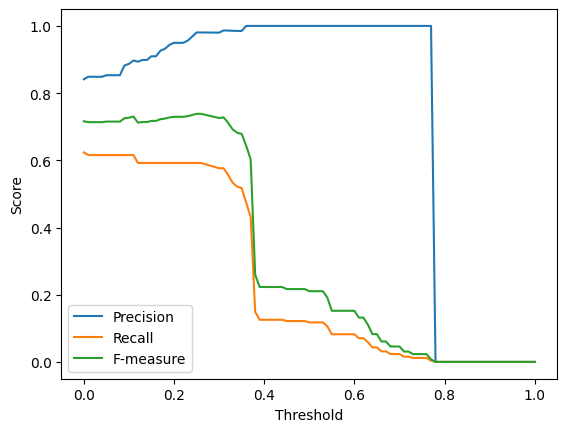

In [181]:
# Plot precision, recall, and F-measure
#plt.plot(threshold_list, acc_list, label='Accuracy')
plt.plot(threshold_list, precision_list, label='Precision')
plt.plot(threshold_list, recall_list, label='Recall')
plt.plot(threshold_list, f_measure_list, label='F-measure')

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

# Display the graph
plt.show()

In [182]:
best_confusion_list = confusion_matrix_dict[best_threshold]
d = {x:best_confusion_list.count(x) for x in best_confusion_list}
d

{'TRUE POSITIVE': 151,
 'FALSE NEGATIVE': 104,
 'TRUE NEGATIVE': 70,
 'FALSE POSITIVE': 3}

In [183]:
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
best_f_measure = 0.0
best_threshold = 0.0
threshold_list = np.arange(0, 1.01, 0.01)
acc_list = list()
precision_list = list()
recall_list = list()
f_measure_list = list()
confusion_matrix_dict = dict()

for threshold in tqdm(threshold_list):
    result_list = list()
    
    for _, row in dataset.iterrows():
        equals = row['equals']

        div_value = row['div_prob']
        if div_value > threshold:
            if equals == 'FALSE' or (type(equals) == bool and equals == False):
                result_list.append('TRUE POSITIVE')
            else:
                result_list.append('FALSE POSITIVE')
        else:
            if equals == 'FALSE' or (type(equals) == bool and equals == False):
                result_list.append('FALSE NEGATIVE')
            else:
                result_list.append('TRUE NEGATIVE')
    
    
    confusion_matrix_dict[threshold] = result_list
    
    true_positive = result_list.count('TRUE POSITIVE')
    true_negative = result_list.count('TRUE NEGATIVE')
    false_positive = result_list.count('FALSE POSITIVE')
    false_negative = result_list.count('FALSE NEGATIVE')
    
    acc = calc_accuracy(true_positive, true_negative, false_positive, false_negative)
    precision = calc_precision(true_positive, false_positive)
    recall = calc_recall(true_positive, false_negative)
    f_measure = calc_f_measure(precision, recall)
    
    acc_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    f_measure_list.append(f_measure)
    
    if f_measure > best_f_measure:
        best_acc = acc
        best_precision = precision
        best_recall = recall
        best_f_measure = f_measure
        best_threshold = threshold

  0%|          | 0/101 [00:00<?, ?it/s]

In [184]:
print(best_threshold)
print(best_acc)
print(best_precision)
print(best_recall)
print(best_f_measure)

0.13
0.7378048780487805
0.42857142857142855
0.5342465753424658
0.47560975609756095


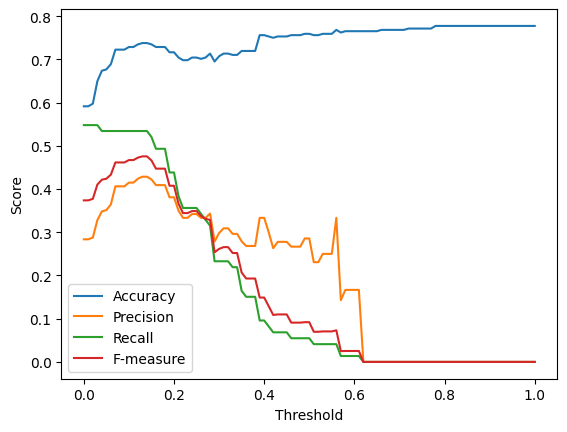

In [185]:
# Plot precision, recall, and F-measure
plt.plot(threshold_list, acc_list, label='Accuracy')
plt.plot(threshold_list, precision_list, label='Precision')
plt.plot(threshold_list, recall_list, label='Recall')
plt.plot(threshold_list, f_measure_list, label='F-measure')

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

# Display the graph
plt.show()

In [186]:
best_confusion_list = confusion_matrix_dict[best_threshold]
d = {x:best_confusion_list.count(x) for x in best_confusion_list}
d

{'TRUE NEGATIVE': 203,
 'FALSE NEGATIVE': 34,
 'FALSE POSITIVE': 52,
 'TRUE POSITIVE': 39}

In [192]:
dataset[(dataset['div_prob'] > 0.13) & (dataset['equals'] == True)]

,Unnamed: 0,e1,p1,o1,e2,p2,o2,equals,true,false,equiv_prob,div_prob
9,9,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Rob_Paulsen,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.robpaulsen.com/,http://dbpedia.org/resource/Rob_Paulsen,http://dbpedia.org/property/website,https://web.archive.org/web/20200811180903/https:/robpaulsenlive.com/,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.557769
20,20,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Alex_Maleev,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://maleev.com/,http://dbpedia.org/resource/Alex_Maleev,http://dbpedia.org/property/website,http://www.maleev.com,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.384301
30,30,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Greg_Rucka,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.gregrucka.com,http://dbpedia.org/resource/Greg_Rucka,http://dbpedia.org/property/website,http://www.gregrucka.com/,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.384301
39,39,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Abrams_Books,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/founded,1949,http://dbpedia.org/resource/Abrams_Books,http://dbpedia.org/property/founded,1949-11-03,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.355646
52,52,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/John_Jackson_Miller,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.farawaypress.com/,http://dbpedia.org/resource/John_Jackson_Miller,http://dbpedia.org/property/website,http://www.farawaypress.com,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.384301
66,66,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Jennifer_Hale,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/website,http://www.jenniferhale.com/,http://dbpedia.org/resource/Jennifer_Hale,http://dbpedia.org/property/website,https://jenniferhale.com/,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.650194
73,73,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_Brigman,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/June_Brigman,http://dbpedia.org/property/nationality,http://dbpedia.org/resource/People_of_the_United_States,True,TRUE NEGATIVE,FALSE POSITIVE,0.113134,0.263979
74,74,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/June_Brigman,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/nationality,American,http://dbpedia.org/resource/June_Brigman,http://dbpedia.org/ontology/nationality,http://dbpedia.org/resource/People_of_the_United_States,True,TRUE NEGATIVE,FALSE POSITIVE,0.116754,0.272426
77,77,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_TIE_Fighter,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/developer,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Totally_Games,http://dbpedia.org/resource/Star_Wars:_TIE_Fighter,http://dbpedia.org/ontology/developer,http://dbpedia.org/resource/Totally_Games,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.298926
78,78,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/Star_Wars:_TIE_Fighter,http://dbkwik.webdatacommons.org/starwars.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/starwars.wikia.com/resource/LucasArts,http://dbpedia.org/resource/Star_Wars:_TIE_Fighter,http://dbpedia.org/ontology/publisher,http://dbpedia.org/resource/LucasArts,True,TRUE NEGATIVE,FALSE POSITIVE,0.000000,0.344672


# Find wrong triples

In [184]:
threshold_common_triple_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent
0,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://dbkwik.webdatacommons.org/ontology/abstract,The following is a list of ambassadors.\n\n,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://dbkwik.webdatacommons.org/ontology/abstract,The following is a list of ambassadors.\n\n,string,string,0.966667,0.966667,0.000000
1,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/dis,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/dis,entity,entity,0.966667,0.870000,0.096667
2,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/2004/02/skos/core#altLabel,Ambassadors,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/2004/02/skos/core#altLabel,Ambassadors,string,string,0.534698,0.534698,0.000000
3,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#comment,The following is a list of ambassadors.\n\n,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#comment,The following is a list of ambassadors.\n\n,string,string,0.966667,0.966667,0.000000
4,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#label,Ambassadors,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#label,Ambassadors,string,string,0.966547,0.966547,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
98281,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/R!ot,http://www.w3.org/2000/01/rdf-schema#comment,"R!ot, also known as R!ot Pictures, is a production company located in Santa Monica, California and New York which provided digital optical effects for the Star Trek: Enterprise first season episode """" and for the Star Trek feature film . The company is a collaboration with Encore Media and is owned by Ascent Media. [1] The company was headed by executive producer Matthew McManus and Director of Production Ada Anderson between 2006 and 2008.\n",http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Rot,http://www.w3.org/2000/01/rdf-schema#comment,"""The Rot"" was the nickname for a genetically transmitted disease which exclusively affected Selelvians. Symptoms included abdominal cramps, headaches, nausea drowsiness and lethargy.\n\n",string,string,0.501213,0.428537,0.072676
98282,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Voyager_(publisher),http://dbkwik.webdatacommons.org/ontology/abstract,"Voyager is a publishing imprint of HarperCollins.\nIt began as an imprint of HarperCollins UK in the 1990s and expanded to their Australian branch. In 2011, it was relaunched when HarperCollins' Eos Books was rebranded as ""Harper Voyager"" and merged with the Voyager imprint, creating a global imprint from HarperCollins for all of their science fiction and fantasy related novels.\nThe original imprint was responsible for printing the UK release of James Van Hise' The Unauthorized History of Trek in 1995.\n\n",http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Voyager_(mirror),http://dbkwik.webdatacommons.org/ontology/abstract,"In different permutations of the mirror universe, the regular universe's USS Voyager is one of many starships to have an alternate reality counterpart.\n\n",string,string,0.501013,0.428366,0.072647
98283,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Voyager_(publisher),http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wiki

In [185]:
different_df = threshold_common_triple_df[threshold_common_triple_df['divergent'] > 0.5]

In [186]:
def check_if_equals(obj, predicate_type):
    obj_type = check_object_type(obj)
    
    return not object_predicate_same_type(obj_type, predicate_type)

In [187]:
different_df['o1_is_outlier'] = different_df.apply(lambda x: check_if_equals(x['o1'], x['p1_type']), axis=1)

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4528/1923279114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_df['o1_is_outlier'] = different_df.apply(lambda x: check_if_equals(x['o1'], x['p1_type']), axis=1)


In [188]:
different_df['o2_is_outlier'] = different_df.apply(lambda x: check_if_equals(x['o2'], x['p2_type']), axis=1)

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4528/622131639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_df['o2_is_outlier'] = different_df.apply(lambda x: check_if_equals(x['o2'], x['p2_type']), axis=1)


In [189]:
len(threshold_common_triple_df)

63775

In [138]:
threshold_common_triple_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent
0,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://dbkwik.webdatacommons.org/ontology/abstract,The following is a list of ambassadors.\n\n,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://dbkwik.webdatacommons.org/ontology/abstract,The following is a list of ambassadors.\n\n,string,string,0.966667,0.966667,0.000000
1,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/dis,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/dis,entity,entity,0.966667,0.290000,0.676667
2,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/2004/02/skos/core#altLabel,Ambassadors,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/2004/02/skos/core#altLabel,Ambassadors,string,string,0.534698,0.534698,0.000000
3,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#comment,The following is a list of ambassadors.\n\n,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#comment,The following is a list of ambassadors.\n\n,string,string,0.966667,0.966667,0.000000
4,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#label,Ambassadors,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/2000/01/rdf-schema#label,Ambassadors,string,string,0.966547,0.966547,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
98281,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/R!ot,http://www.w3.org/2000/01/rdf-schema#comment,"R!ot, also known as R!ot Pictures, is a production company located in Santa Monica, California and New York which provided digital optical effects for the Star Trek: Enterprise first season episode """" and for the Star Trek feature film . The company is a collaboration with Encore Media and is owned by Ascent Media. [1] The company was headed by executive producer Matthew McManus and Director of Production Ada Anderson between 2006 and 2008.\n",http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Rot,http://www.w3.org/2000/01/rdf-schema#comment,"""The Rot"" was the nickname for a genetically transmitted disease which exclusively affected Selelvians. Symptoms included abdominal cramps, headaches, nausea drowsiness and lethargy.\n\n",string,string,0.501213,0.428537,0.072676
98282,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Voyager_(publisher),http://dbkwik.webdatacommons.org/ontology/abstract,"Voyager is a publishing imprint of HarperCollins.\nIt began as an imprint of HarperCollins UK in the 1990s and expanded to their Australian branch. In 2011, it was relaunched when HarperCollins' Eos Books was rebranded as ""Harper Voyager"" and merged with the Voyager imprint, creating a global imprint from HarperCollins for all of their science fiction and fantasy related novels.\nThe original imprint was responsible for printing the UK release of James Van Hise' The Unauthorized History of Trek in 1995.\n\n",http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Voyager_(mirror),http://dbkwik.webdatacommons.org/ontology/abstract,"In different permutations of the mirror universe, the regular universe's USS Voyager is one of many starships to have an alternate reality counterpart.\n\n",string,string,0.501013,0.428366,0.072647
98283,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Voyager_(publisher),http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wiki

In [190]:
len(different_df)

9814

In [191]:
len(different_df[different_df['o1_is_outlier'] | different_df['o2_is_outlier']])

40

In [192]:
different_df[different_df['o1_is_outlier'] | different_df['o2_is_outlier']].sort_values(
    'divergent', ascending=False)[['e1', 'p1', 'o1', 'p1_type', 'e2', 'p2', 'o2', 'p2_type', 'divergent']][20:]



,e1,p1,o1,p1_type,e2,p2,o2,p2_type,divergent
34400,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Barash,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/species,Unknown,entity,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Barash,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/species,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Insect,entity,0.555430
12225,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Fire_with_Fire,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/isbn,178565649,undefined,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Fire_with_Fire,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/isbn,9783864258510,string,0.540766
17086,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/The_Art_of_Star_Trek,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/publisher,"Japan Mix, Inc.",entity,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/The_Art_of_Star_Trek,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Pocket_Books,entity,0.534923
21550,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/The_Needs_of_the_Many,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/isbn,143918657,undefined,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/The_Needs_of_the_Many,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/isbn,9781439186572,string,0.531643
7925,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/The_Star_Trek_Compendium,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/publisher,Japan Mix,entity,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/The_Star_Trek_Compendium,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/publisher,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Pocket_Books,entity,0.522998
55413,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/World_Beneath_the_Waves,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/stardate,19,undefined,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/World_Beneath_the_Waves,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/stardate,69963.0,numbers,0.521744
61850,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/The_Perfect_Dream,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/stardate,30,undefined,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/The_Perfect_Dream,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/stardate,109152.0,numbers,0.520155
1643,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Silversides,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/datestatus,2360.0,numbers,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Silversides,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,active,categorical,0.511844
1651,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Umibozu,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/datestatus,2360.0,numbers,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Umibozu,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,active,categorical,0.511793
1699,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Seaview,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/datestatus,2360.0,numbers,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Seaview,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,active,categorical,0.511424


In [193]:
threshold_common_triple_df.groupby(['p1', 'p2'])

In [148]:
def convert_prop_types(pred_type_dict):
    new_type_dict = dict()
    
    for p, p_dict in pred_type_dict.items():
        new_type_dict[p] = dict()
        for obj_type in p_dict:
            new_obj_type = ''
            
            if obj_type == URIRef:
                new_obj_type = ENTITY
            elif obj_type in string_types:
                new_obj_type = STRING
            elif obj_type in number_types:
                new_obj_type = NUMBER
            elif obj_type ==datetime.date:
                new_obj_type = DATE
            else:
                new_obj_type = UNDEFINED
            
            if not new_obj_type in new_type_dict[p]:
                new_type_dict[p][new_obj_type] = 0
            
            new_type_dict[p][new_obj_type] += p_dict[obj_type]
    return new_type_dict

In [149]:
converted_p1_prop_type_dict = convert_prop_types(p1_prop_type_dict)

In [151]:
converted_p2_prop_type_dict = convert_prop_types(p2_prop_type_dict)

In [158]:
def check_if_uncommon(obj, pred_types):
    obj_type = check_object_type(obj)
    
    if not obj_type in pred_types:
        return True
    
    if pred_types[obj_type] < 0.2:
        return True
    return False

In [159]:
different_df['o1_is_outlier'] = different_df.apply(
    lambda x: check_if_uncommon(x['o1'], converted_p1_prop_type_dict[x['p1']]), axis=1)

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4528/3845078038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_df['o1_is_outlier'] = different_df.apply(


In [160]:
different_df['o2_is_outlier'] = different_df.apply(
    lambda x: check_if_uncommon(x['o2'], converted_p2_prop_type_dict[x['p2']]), axis=1)

/var/folders/6f/k2t20zbs4db5khp6mgdq_06m0000gn/T/ipykernel_4528/1698585172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_df['o2_is_outlier'] = different_df.apply(


In [161]:
different_df

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent,o1_is_outlier,o2_is_outlier
1,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Ambassadors,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/dis,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Ambassadors,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/dis,entity,entity,0.966667,0.29,0.676667,False,False
6,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Unnamed_Federation_starships,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/class,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Unnamed_Federation_starships,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/n,entity,entity,0.966667,0.00,0.966667,False,False
11,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Unnamed_Efrosians,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/see-list,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Unnamed_Efrosians,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/c,entity,entity,0.966667,0.00,0.966667,False,False
18,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Unnamed_Borg_starships,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/voy,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Unnamed_Borg_starships,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/memoryalpha,entity,entity,0.966667,0.00,0.966667,False,False
23,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Unnamed_Romulan_starships,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/mbeta,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Unnamed_Romulan_starships,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/c,entity,entity,0.966667,0.00,0.966667,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98263,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Alexander_(warrior),http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/bginfo,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Alexander_(mirror),http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/characterbox,entity,entity,0.504140,0.00,0.504140,False,False
98268,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Sloth,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/bginfo,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/S%27loth,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/characterbox,entity,entity,0.503949,0.00,0.503949,False,False
98273,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Broken_Bow_(soundtrack),http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/sidebar_soundtrack,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Broken_Bow_(town),http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/class/n,entity,entity,0.501806,0.00,0.501806,False,False
98278,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/R!ot,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/class/imdb-link,http://dbkwik.webdatacommons.org

In [162]:
different_df[different_df['o1_is_outlier'] | different_df['o2_is_outlier']]

,e1,p1,o1,e2,p2,o2,p1_type,p2_type,prob,equals,divergent,o1_is_outlier,o2_is_outlier
118,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Son%27a_shuttle,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Auxiliary_space_vessel,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Son%27a_shuttle,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Shuttlecraft,undefined,categorical,0.700686,0.000000,0.700686,False,True
1446,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Enterprise_(NCC-1701-A),http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/status,Decommissioned,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Enterprise_(NCC-1701-A),http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Chal,categorical,categorical,0.843710,0.216954,0.626756,False,True
1448,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Enterprise_(NCC-1701-A),http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/datestatus,2293,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Enterprise_(NCC-1701-A),http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Chal,numbers,categorical,0.512711,0.000000,0.512711,False,True
1643,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Silversides,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/datestatus,2360.0,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Silversides,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,active,numbers,categorical,0.511844,0.000000,0.511844,True,False
1651,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/USS_Umibozu,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/datestatus,2360.0,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/USS_Umibozu,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/status,active,numbers,categorical,0.511793,0.000000,0.511793,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84177,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Xindi-Reptilian_warship,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Warship,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Contortrix_class,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Escort,undefined,categorical,0.502597,0.000000,0.502597,False,True
84294,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Romulan_Bird-of-Prey_(23rd_century),http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/type,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Bird-of-Prey,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Vas_Hatham_class,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/type,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Warbird,undefined,categorical,0.501636,0.000000,0.501636,False,True
85315,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Sarah_April,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/maritalStatus,http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/resource/Marriage,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/Sarah_Poole-April,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/maritalStatus,http://dbkwik.webdatacommons.org/memory-beta.wikia.com/resource/October,undefined,categorical,0.520638,0.000000,0.520638,False,True
85316,http://dbkwik.webdatacommons.o